In [12]:

"""
Evolving an adiabatic shock wave
@author: Sneha Nair

March 19th 2022
"""
import numpy as np
import matplotlib.pyplot as plt

In [13]:
## Please note we will be using Professor Lee's code as a model 
# Set up the grid, time and grid spacing
Ngrid = 100
Nsteps = 1250
dt = 0.01
dx = 2.0
#This is for our adiabatic index since we are considering adiabatic shock
gamma = 5/3 

## Establishing the relavnt grids
x = np.arange(Ngrid) * dx # grid
f1 = np.ones(Ngrid) # rho
f2 = np.zeros(Ngrid) # rho x u
u = np.zeros(Ngrid+1) # advective velocity (keep the 1st and last element zero)

#Since we have to consider the energy lets create another variable where we have rho * total energy
E = np.ones(Ngrid) 

## The pressure is 
pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)

# Sound speed squared
cs = (pressure * gamma ) / f1


velocity_intial = f2/f1
mach_initial =velocity_intial/np.sqrt(cs)

In [14]:
## Professor Lee's Advection Function:
def advection(f, u, dt, dx):
    # calculating flux terms
    J = np.zeros(len(f)+1) # keeping the first and the last term zero
    J[1:-1] = np.where(u[1:-1] > 0, f[:-1] * u[1:-1], f[1:] * u[1:-1])
    f = f - (dt / dx) * (J[1:] - J[:-1]) #update

    return f

## Now let's write a function that will compute the relevant gradient for a given value. 
def grad(f,pressure):
    f[1:-1] = f[1:-1] -  0.5*(dt/dx) * (pressure[2:] - pressure[:-2]) 
    
def boundary_conditions(f2,pressure):
    f2[0] = f2[0] -  0.5*(dt/dx) * (pressure[1] - pressure[0]) 
    f2[-1] = f2[-1] -  0.5*(dt/dx) * (pressure[-1] - pressure[-2])

def boundary_conditions_2(E,Pressure):
    E[0] = E[0] -  0.5*(dt/dx)*(Pressure[1] - Pressure[0]) 
    E[-1] = E[-1] -  0.5*(dt/dx)*(Pressure[-1]-Pressure[-2])
    
    
def advection_vel(u,fa,fb):
    u[1:-1] = 0.5 * ((fb[:-1] / fa[:-1]) + (fb[1:] / fa[1:])) 

    

In [15]:
## Now that we have defined all of our methods let's start looping through
# Apply initial Gaussian perturbation to energy 
Amp, sigma = 10000, Ngrid/10
E = E + Amp * np.exp(-(x - x.max()/2) ** 2 / sigma ** 2)

In [16]:
%matplotlib
# plotting
plt.ion()
fig, ax = plt.subplots(2,1)

# Density plot
x1, = ax[0].plot(x, f1,color='y')
ax[0].set_xlim([0, dx*Ngrid])
ax[0].set_ylim([0, 5])
ax[0].set_xlabel('x')
ax[0].set_ylabel('Density')

# Mach number plot
x2, = ax[1].plot(x, mach_initial,color='b')
ax[1].set_xlim([0, dx*Ngrid])
ax[1].set_ylim([-4, 4])
ax[1].set_xlabel('x')
ax[1].set_ylabel('Mach Number')

fig.canvas.draw()


## To make a snapshot of the plot at relevant times

snapshot_density = np.zeros(Ngrid)
snapshot_u = np.zeros(Ngrid)
for ct in range(Nsteps):
    ## advection velocity at the cell interface
    u[1:-1] = 0.5 * ((f2[:-1] / f1[:-1]) + (f2[1:] / f1[1:])) 
    #update density and momentum
    f1 = advection(f1, u, dt, dx)
    f2 = advection(f2, u, dt, dx)

    # We need to update the relevant pressure and speed sound squared terms as well
    pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)
    cs = gamma*pressure/f1
    # Now compute the pressure gradient and impose boundary conditions
    grad(f2,pressure)
    boundary_conditions(f2,pressure)

    #Let's try to now use our method to get the advection velocity and use it to advect the energy
    advection_vel(u,f1,f2) 
    E = advection(E, u, dt, dx)

    #Now we need to recalculate the pressure and velocity
    pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)
    velocity= f2/f1
    ## allows us to compute the energy gradient and imposing the correct boundary conditions
    p_e= pressure*velocity
    grad(E,p_e)
    boundary_conditions_2(E,p_e)

    # again updating the pressure and sound speed values so that we can obtain the mach number to plot. 
    pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)
    cs = gamma * pressure / f1
    velocity= f2/f1
    mach = velocity/np.sqrt(cs)
    
    if (ct==150):
        snapshot_density =f1
        snapshot_u =f2/f1
    
    #plot the data 
    x1.set_ydata(f1)
    x2.set_ydata(mach)
    fig.canvas.draw()
    plt.pause(0.001)

Using matplotlib backend: MacOSX


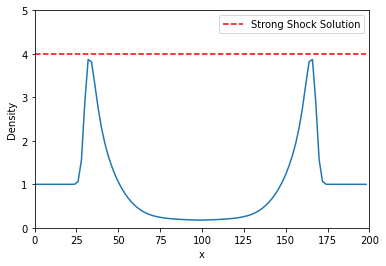

In [17]:
%matplotlib inline
## Now let's answer the questions which have been posed. 
## Question 1: The ratio of densities pre and post shock. 

'''
In general, we set the density preshock to be approximately 1 where as if we look at the snapshot of the density plot 
after the shock, we have that the density is at roughly 4. If we take this a ration we get Ratio = (1/4) .
This agrees with the strong shock condition. Since in class for a monotomic gas ie Gamma = 5/3 we derived that 
the ratio should be about 1/4.

'''
plt.xlim([0,200])
plt.ylim([0,5])
plt.xlabel('x')
plt.ylabel('Density')
plt.plot(x,snapshot_density)
plt.plot(x,np.zeros(Ngrid)+4,color='r',linestyle='dashed',label='Strong Shock Solution')
plt.legend()





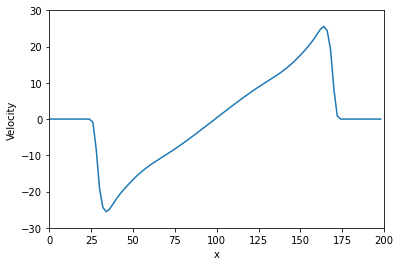

In [18]:
## Question 2: The width of my shock and what set the width.

'''
The width of my shock as mentioned in class notes is del (x) = viscoity/u where we can get the viscosity as  dx^2 / (2*dt) = (4)/(2*0.01) = 200. If 
we look at the included snapshot at the end of the shock we have that the mach number read aboutt roughly 25. Thus our 
width is about 200/25 = 8 . Which if we look at the plot makes sense. Let's verify by varying dt and dx. 

'''
plt.xlabel('x')
plt.ylabel('Velocity')
plt.xlim([0,200])
plt.ylim([-30,30])
plt.plot(x,snapshot_u)

## Varying the Parameters
## Have to re-run the code for a different dt and dx value

In [19]:
# Here we are varying our parameters.
dt = 0.01
dx = 5.0

In [20]:
## Rerunning the code:
gamma = 5/3 

## Establishing the relavnt grids
x = np.arange(Ngrid) * dx # grid
f1 = np.ones(Ngrid) # rho
f2 = np.zeros(Ngrid) # rho x u
u = np.zeros(Ngrid+1) # advective velocity (keep the 1st and last element zero)

#Since we have to consider the energy lets create another variable where we have rho * total energy
E = np.ones(Ngrid) 

## The pressure is 
pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)

# Sound speed squared
cs = (pressure * gamma ) / f1


velocity_intial = f2/f1
mach_initial =velocity_intial/np.sqrt(cs)

In [21]:

## Professor Lee's Advection Function:
def advection(f, u, dt, dx):
    # calculating flux terms
    J = np.zeros(len(f)+1) # keeping the first and the last term zero
    J[1:-1] = np.where(u[1:-1] > 0, f[:-1] * u[1:-1], f[1:] * u[1:-1])
    f = f - (dt / dx) * (J[1:] - J[:-1]) #update

    return f

## Now let's write a function that will compute the relevant gradient for a given value. 
def grad(f,pressure):
    f[1:-1] = f[1:-1] -  0.5*(dt/dx) * (pressure[2:] - pressure[:-2]) 
    
def boundary_conditions(f2,pressure):
    f2[0] = f2[0] -  0.5*(dt/dx) * (pressure[1] - pressure[0]) 
    f2[-1] = f2[-1] -  0.5*(dt/dx) * (pressure[-1] - pressure[-2])

def boundary_conditions_2(E,Pressure):
    E[0] = E[0] -  0.5*(dt/dx)*(Pressure[1] - Pressure[0]) 
    E[-1] = E[-1] -  0.5*(dt/dx)*(Pressure[-1]-Pressure[-2])
    
    
def advection_vel(u,fa,fb):
    u[1:-1] = 0.5 * ((fb[:-1] / fa[:-1]) + (fb[1:] / fa[1:])) 

In [22]:
## Now that we have defined all of our methods let's start looping through
# Apply initial Gaussian perturbation to energy 
Amp, sigma = 10000, Ngrid/10
E = E + Amp * np.exp(-(x - x.max()/2) ** 2 / sigma ** 2)

In [23]:
%matplotlib
# plotting
plt.ion()
fig, ax = plt.subplots(2,1)

# Density plot
x1, = ax[0].plot(x, f1,color='y')
ax[0].set_xlim([0, dx*Ngrid])
ax[0].set_ylim([0, 5])
ax[0].set_xlabel('x')
ax[0].set_ylabel('Density')

# Mach number plot
x2, = ax[1].plot(x, mach_initial,color='b')
ax[1].set_xlim([0, dx*Ngrid])
ax[1].set_ylim([-4, 4])
ax[1].set_xlabel('x')
ax[1].set_ylabel('Mach Number')

fig.canvas.draw()


## To make a snapshot of the plot at relevant times

snapshot_density = np.zeros(Ngrid)
snapshot_u = np.zeros(Ngrid)
Nsteps = 500
for ct in range(Nsteps):
    ## advection velocity at the cell interface
    u[1:-1] = 0.5 * ((f2[:-1] / f1[:-1]) + (f2[1:] / f1[1:])) 
    #update density and momentum
    f1 = advection(f1, u, dt, dx)
    f2 = advection(f2, u, dt, dx)

    # We need to update the relevant pressure and speed sound squared terms as well
    pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)
    cs = gamma*pressure/f1
    # Now compute the pressure gradient and impose boundary conditions
    grad(f2,pressure)
    boundary_conditions(f2,pressure)

    #Let's try to now use our method to get the advection velocity and use it to advect the energy
    advection_vel(u,f1,f2) 
    E = advection(E, u, dt, dx)

    #Now we need to recalculate the pressure and velocity
    pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)
    velocity= f2/f1
    ## allows us to compute the energy gradient and imposing the correct boundary conditions
    p_e= pressure*velocity
    grad(E,p_e)
    boundary_conditions_2(E,p_e)

    # again updating the pressure and sound speed values so that we can obtain the mach number to plot. 
    pressure = (gamma - 1)/gamma * (E - 0.5*f2**2/f1)
    cs = gamma * pressure / f1
    velocity= f2/f1
    mach = velocity/np.sqrt(cs)
    
    if (ct==400):
        snapshot_density =f1
        snapshot_u =f2/f1
    
    #plot the data 
    x1.set_ydata(f1)
    x2.set_ydata(mach)
    fig.canvas.draw()
    plt.pause(0.001)

Using matplotlib backend: MacOSX


'\nHere we get something more odd. The width is greater here. So increasing the dx increases the width of the\nwave. \n'

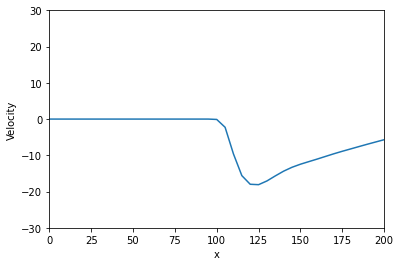

In [24]:
%matplotlib inline
plt.xlabel('x')
plt.ylabel('Velocity')
plt.xlim([0,200])
plt.ylim([-30,30])
plt.plot(x,snapshot_u)

'''
Here we get something more odd. The width is greater here. So increasing the dx increases the width of the
wave. 
'''